In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tinymlgen import port

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.8.0


In [2]:
#define the number of classes of the image...these are NOAA, so 

num_classes = 3

#this is a fn to make sure the labels go from 0- (num_classes-1)

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image

In [3]:
#build data flow routines, gettign the data from the files to the netowrk...

#first we decide how much of the data is training and how much is validation
split = 0.4

# Define dirs and files where the images and labels are.. Use doodler to get labels for your images!
image_dir = 'data/segmentation/images'
label_dir = 'data/segmentation/labels'

#to make it deterministic, set the seed
SEED = 201

# We will use generators to flow the data.. for both training and validaton
# We also add some weak data-augmentation, and rescale the images here.
# note that we are using the generator to split the data. 
train_image_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)

train_mask_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True,
                                   preprocessing_function = D_Filter,
                                   validation_split = split )

#set batch Size for the model — how many images go into the network at each
#step. 
batch_size = 1

#set Image size. We are using a UNET based on Segmentation Zoo.. 
# size choices are:
#
#(RGB so imshape is 3)
pix_dim_x = 448
pix_dim_y = 448
imsize = (pix_dim_x,pix_dim_y) 
imshape = (pix_dim_x,pix_dim_y,3)

masksize = (pix_dim_x,pix_dim_y) 


### This is where we set the generator to flow images from the folders into the 
#training. The is a generator for the image and another for the mask. And also 
# generators for the traing and val.. so 4 total.:

train_image_generator = train_image_datagen.flow_from_directory(image_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset ='training')

train_label_generator = train_mask_datagen.flow_from_directory(label_dir,
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'training')

# we merge the two training generators (image and mask) so that it looks like a
# a single generator 
train_generator = zip(train_image_generator, train_label_generator)


# Flow validation images in batches 


val_image_generator = train_image_datagen.flow_from_directory(image_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = imsize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    interpolation = "nearest",
                                                    subset = 'validation')

val_label_generator = train_mask_datagen.flow_from_directory(label_dir, # same directory as training data
                                                    class_mode = None,
                                                    batch_size = batch_size,
                                                    target_size = masksize,
                                                    seed = SEED,
                                                    shuffle = False,
                                                    color_mode = "grayscale",
                                                    interpolation = "nearest",
                                                    subset = 'validation')

#merge generators
validation_generator = zip(val_image_generator, val_label_generator)


Found 18 images belonging to 1 classes.
Found 18 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


In [4]:
# model that uses resizing nearest neighbor layers
# OpenMV TFlite supported operators: 
# https://github.com/openmv/tensorflow/blob/master/tensorflow/lite/micro/all_ops_resolver.cc
filepath = './models/Unet_water_resizelayers_test'
model = tf.keras.models.load_model(filepath)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 7)  91          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 7)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 14  406         ['max_pooling2d[0][0]']      

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
num_calibration_steps = 1

def representative_dataset_gen():
    for image_batch in train_image_generator.next():
        image_batch = image_batch[None,:,:,:]
        yield [image_batch]
        
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

tflite_model = converter.convert()

with open('unet_resize_test2.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

INFO:tensorflow:Assets written to: C:\Users\joe\AppData\Local\Temp\tmpx1it1g8w\assets


C:\Users\joe\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [6]:
# test the quantized model

In [7]:
interpreter = tf.lite.Interpreter(model_path="unet_resize_test.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
input_details

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 448, 448,   3]),
  'shape_signature': array([ -1, 448, 448,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.003921568859368563, 0),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 49,
  'shape': array([  1, 448, 448,   3]),
  'shape_signature': array([ -1, 448, 448,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0),
  'quantization_parameters': {'scales': array([0.00390625], dtype=float32),
   'zero_points': array([0]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
# load and prepare image for testing
from PIL import Image
im = Image.open("data/segmentation/images/images/CAM_BF_01_20220518011222 copy_jmbolewitz.jpg")

In [14]:
print(im.size)
res_im = im
np_res_im = np.array(res_im).astype('uint8')

(448, 448)


In [16]:
np_res_im = np.array(res_im).astype('uint8')

In [17]:
input_details[0]['shape']

array([  1, 448, 448,   3])

In [18]:
np_res_im.shape

(448, 448, 3)

In [27]:
if len(np_res_im.shape) == 3:
    np_res_im = np.expand_dims(np_res_im, 0)
input_shape = input_details[0]['shape']
input_data = np_res_im
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

In [20]:
output_data.shape

(1, 448, 448, 3)

In [21]:
output_data[0].shape

(448, 448, 3)

In [28]:
labelsArrays = ["water","no_water","other"]

In [29]:
mSegmentBits = np.zeros((448,448)).astype(int)
outputbitmap = np.zeros((448,448)).astype(int)
for y in range(448):
    for x in range(448):
        maxval = 0
        mSegmentBits[x][y]=0
        
        for c in range(3):
            value = output_data[0][y][x][c]
            if c == 0 or value > maxVal:
                maxVal = value
                mSegmentBits[y][x] = c
#         print(mSegmentBits[x][y])
        label = labelsArrays[mSegmentBits[x][y]]
#         print(label)
        if(mSegmentBits[y][x]==0):
            outputbitmap[y][x]=255
        elif(mSegmentBits[y][x]==1):
            outputbitmap[y][x]=120
        else:
            outputbitmap[y][x]=0

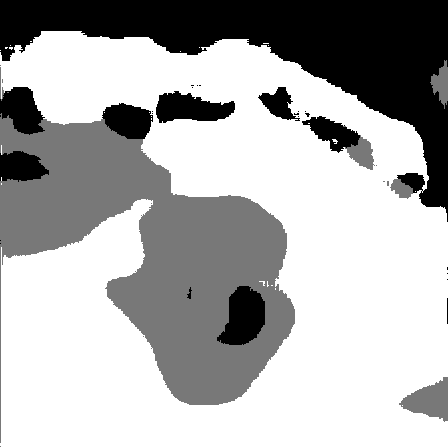

In [30]:
from PIL import Image
temp_outputbitmap= outputbitmap
PIL_image = Image.fromarray(np.uint8(temp_outputbitmap)).convert('L')
PIL_image

(448, 448)


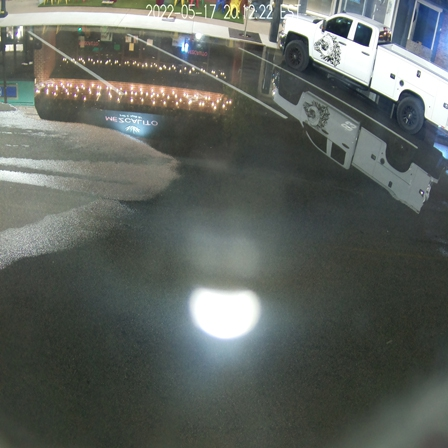

In [31]:
print(im.size)
im

In [ ]:
# use this unix command to convert the .tflite file into a C array
# xxd -i converted_model.tflite > model_data.cc